In [12]:
import pandas as pd
import seaborn as sns

def get_strain_data(
    tsv_name, last_index=None,
):
    df = pd.read_csv(tsv_name, sep="\t")
    if last_index is None:
        last_index = len(df) - 1
    strain_values = convert_pixels_to_strain(
        bottom_y_value=df["y_pos"][0], y_pixel_values=df["y_pos"][1:last_index].to_list()
    )
    return strain_values

def convert_pixels_to_strain(bottom_y_value, y_pixel_values):
    top_y_value = y_pixel_values[0]
    original_len = bottom_y_value - top_y_value
    return [((bottom_y_value - y_pixel) / original_len) - 1 for y_pixel in y_pixel_values]

In [ ]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib as mpl


# def piecewise_linear(x, x0, y0, slope):
#     return np.piecewise(
#         x, [x <= x0, x > x0], [lambda x: slope * (x - x0) + y0, lambda x: y0]
#     )

def piecewise_linear(x, x0, y0, slope):
    x = np.asarray(x, dtype=float)  # <-- ensure float input
    return np.piecewise(
        x,
        [x <= x0, x > x0],
        [lambda x: slope * (x - x0) + y0, lambda x: y0]
    )


def fit_piecewise_linear(x_data, y_data, initial_guess=None):
    """
    Fit a piecewise linear model to data and print goodness-of-fit metrics.
    """
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)

    if initial_guess is None:
        y_diff = np.abs(np.diff(y_data))
        potential_breakpoint = np.argmin(y_diff) + 1
        x0_guess = float(x_data[potential_breakpoint])
        y0_guess = float(y_data[potential_breakpoint])

        early_size = max(2, potential_breakpoint // 2)
        x_early = x_data[:early_size]
        y_early = y_data[:early_size]

        if len(x_early) >= 2:
            slope_guess, _ = np.polyfit(x_early, y_early, 1)
        else:
            slope_guess = 0.0

        initial_guess = [x0_guess, y0_guess, slope_guess]

    try:
        params, _ = optimize.curve_fit(piecewise_linear, x_data, y_data, p0=initial_guess)
    except (RuntimeError, TypeError) as e:
        print(f"Curve fitting failed: {e}")
        print("Using initial guess as parameters")
        params = initial_guess

    # Calculate fit and residuals
    y_fit = piecewise_linear(x_data, *params)
    residuals = y_data - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    mse = ss_res / len(y_data)
    rmse = np.sqrt(mse)

    print('y_data', y_data)
    print('yy_fit', y_fit)

    # Print the results
    print("\n--- Fit Results ---")
    print(f"Parameters: {params}")
    print(f"Sum of Squared Residuals (SSR): {ss_res:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root MSE (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r_squared:.4f}")

    return params



def plot_piecewise_fit(
    x_data,
    y_data,
    params,
    title="Piecewise Linear Fit",
    color="#5DADE2",
    marker="x",
    x_label="Time (minutes)",
    y_label="Strain (%)",
    convert_strain_to_percent=True,
):
    
    x0, y0, slope = params
    if convert_strain_to_percent:
        y0 = y0 * 100
        slope = slope * 100
        y_data = [100 * y for y in y_data]

    # Set up the style
    plt.style.use("seaborn-v0_8-whitegrid")
    mpl.rcParams["font.family"] = "Arial"
    mpl.rcParams["figure.facecolor"] = "white"
    mpl.rcParams["axes.facecolor"] = "white"
    mpl.rcParams["axes.linewidth"] = 1.0
    mpl.rcParams["axes.edgecolor"] = "#333333"
    mpl.rcParams["grid.alpha"] = 0.3
    mpl.rcParams["grid.linestyle"] = "--"

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    # Create a smooth x array for plotting the fitted function
    x_fit = np.linspace(min(x_data), max(x_data), 1000)
    y_fit = piecewise_linear(x_fit, x0, y0, slope)

    # Plot data points
    ax.plot(
        x_data,
        y_data,
        color=color,
        marker=marker,
        linestyle="",
        markersize=7,
        markeredgewidth=1.8,
    )

    # Plot fitted function with the same color
    ax.plot(x_fit, y_fit, color=color, linewidth=2.5)

    # Create the function equation text
    if slope > 0:
        slope_sign = "+"
    else:
        slope_sign = "-"
        slope = abs(slope)

    equation = r"$f(x) = \begin{cases} "
    equation += f"{y0:.2f}, & \\text{{if }} x \leq {x0:.2f} \\\\ "
    equation += f"{y0:.2f} {slope_sign} {slope:.4f}(x - {x0:.2f}), & \\text{{if }} x > {x0:.2f} "
    equation += r"\end{cases}$"

    # Print the equation to console for reference
    print(equation)

    # Axis labels with bold formatting
    ax.set_xlabel(x_label, fontsize=12, fontweight="bold")
    ax.set_ylabel(y_label, fontsize=12, fontweight="bold")

    # Title (if provided)
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold", pad=15)

    # Ticks and grid
    ax.tick_params(axis="both", which="major", labelsize=10, width=1, length=4)
    ax.grid(True, linestyle="--", alpha=0.6)

    # Remove top and right spines for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Final layout adjustments
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"{title}.png", dpi=300, bbox_inches="tight")

    return

> /var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_54632/3160692663.py(54)fit_piecewise_linear()
     52     # Calculate fit and residuals
     53     import pdb; pdb.set_trace()
---> 54     y_fit = piecewise_linear(x_data, *params)
     55     import pdb; pdb.set_trace()
     56     residuals = y_data - y_fit

     49         print("Using initial guess as parameters")
     50         params = initial_guess
     51 
     52     # Calculate fit and residuals
     53     import pdb; pdb.set_trace()
---> 54     y_fit = piecewise_linear(x_data, *params)
     55     import pdb; pdb.set_trace()
     56     residuals = y_data - y_fit
     57     ss_res = np.sum(residuals**2)
     58     ss_tot = np.sum((y_data - np.mean(y_data))**2)
     59     r_squared = 1 - (ss_res / ss_tot)

array([ 0.01113139, -0.04259645, -0.0963243 , -0.15005214, -0.20377998,
       -0.25750782, -0.31123566, -0.3649635 , -0.41869135, -0.47241919,
       -0.52614703, -0.57987487, -0.63360271, -0.68733055, -0.7

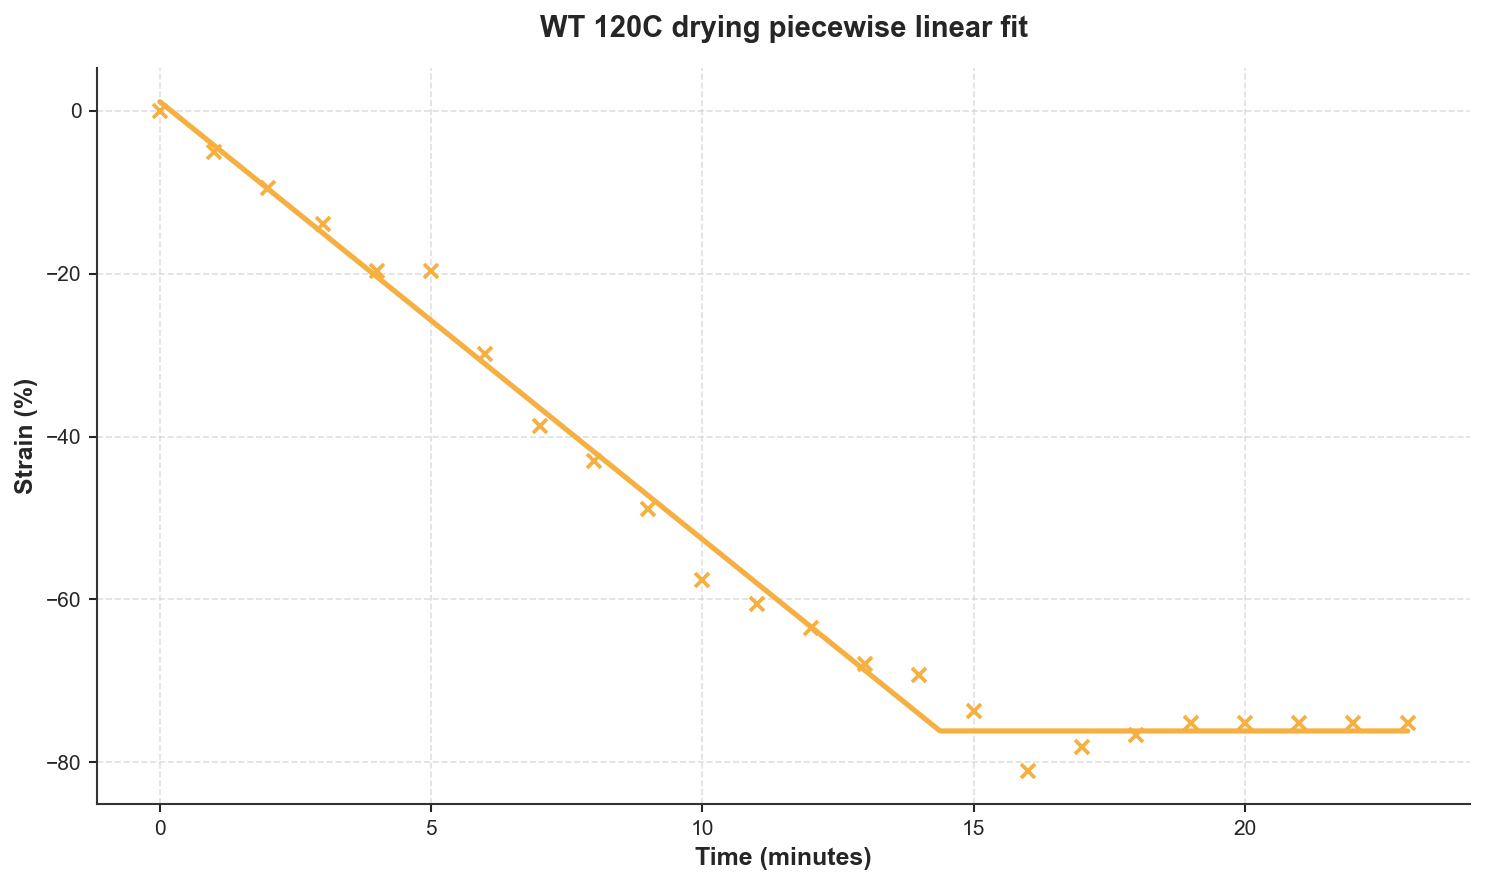

In [14]:
drying_data = get_strain_data('drying_data/120C_strain_data_wt.tsv',last_index=25)

minutes = [idx for idx in range(len(drying_data))]
assert(len(minutes) == len(drying_data))
params = fit_piecewise_linear(minutes, drying_data)
x0_fit, y0_fit, slope_fit = params

plot_piecewise_fit(minutes, drying_data, params, title="WT 120C drying piecewise linear fit", color="#F5B041", marker="x")

In [15]:
bsla_20_strains = get_strain_data('drying_data/120C_strain_data_bsla.tsv',last_index=None)
# This one was taken at 0.1 second intervals 
bsla_minutes = [float(idx / 10) for idx in range(len(bsla_20_strains))]
assert(len(bsla_minutes) == len(bsla_20_strains))
params = fit_piecewise_linear(bsla_minutes, bsla_20_strains)
x0_fit, y0_fit, slope_fit = params
print(x0_fit, y0_fit, slope_fit)
plot_piecewise_fit(bsla_minutes, bsla_20_strains, params, "BslA 120C Piecewise Linear Fit", color="#5DADE2", marker='o')

> /var/folders/_t/vlf4bw_n38x9ytx94_479wt80000gp/T/ipykernel_54632/3160692663.py(54)fit_piecewise_linear()
     52     # Calculate fit and residuals
     53     import pdb; pdb.set_trace()
---> 54     y_fit = piecewise_linear(x_data, *params)
     55     import pdb; pdb.set_trace()
     56     residuals = y_data - y_fit



# Not so relevant, but we have other data too collected for 20C

In [ ]:
# drying_data = get_strain_data('drying_data/20C_strain_data_bsla.tsv',last_index=30)

# minutes = [idx for idx in range(len(drying_data))]
# assert(len(minutes) == len(drying_data))
# params = fit_piecewise_linear(minutes, drying_data)
# x0_fit, y0_fit, slope_fit = params

# plot_piecewise_fit(minutes, drying_data, params, "20C BslA drying piecewise linear fit")

In [ ]:
# drying_data = get_strain_data('drying_data/20C_strain_data_wt.tsv',last_index=None)

# minutes = [idx for idx in range(len(drying_data))]
# assert(len(minutes) == len(drying_data))
# params = fit_piecewise_linear(minutes, drying_data)
# x0_fit, y0_fit, slope_fit = params

# plot_piecewise_fit(minutes, drying_data, params, "20C WT drying piecewise linear fit")